# Pre-procesamiento

El documento original es un documento de MS Excel (.xlsx) compuesto cuyas celdas son tratadas principalmente como texto en Español. Para un correcto procesamiento es necesari lo siguiente:

*1. Cambiar todas las comas (,) por punto y comas (;):* Esto para que no interfiera con la conversión a UTF-8 .csv y el procesamiento realizado en las librerías de python, centradas principalmente en procesar datos en inglés.

*2. Cambiar las letras tildadas y la letra ñ:* Se cambia cada vocal tildada por la vocal sin tilde y la letra Ñ por la letra N. Esto, nuevamente, para que no interfieran con el procesamiento posterior de las librerías de python y para conservar la interpretabilidad. 

*3. Borrar la cabecera:* La cabecera incluye el escudo de la Gobernación de Antioquia y el título de la tabla. Esta file puede interfiere con el procesamiento en AWS y con las librerías, por lo que se optó por suprimirla.

*4. Convertir a UTF-8 .csv:* Esto para facilitar el procesamiento por parte de las librerías de python.

# Procesamiento de duplicados

Con el fin de optimizar el tiempo de procesamiento y tras un análisis del dataset se tomó la decisión de identificar y eliminar los duplicados. Esto implica tener en cuenta que, si bien se pretende conservar el registro más reciente de cada cédula, este registro puede tener información faltante que registros previos de la misma cédula pueden llegar a tener, es por eso que es necesario realizar una especie de "merge", dando como resultado una fila que conserva el object_id (identificador único usado en el sistema de información en la Gobernación) y el registro más reciente de cada columna para cada cédula.

En la última versión de prefirió omitir columnas "volátiles" en el merge; por ejemplo, la información del cuidador. Por columnas volátiles se entienden aquellas columnas que representen información que pueda cambiar con frecuencia y que su mala conservación pueda afectar la interpretabilidad del dataset pues la falta de ésta información también puede significar algo.

## Detección de duplicados

Como paso inicial se creó el método `encontrar_cedulas_duplicadas.py` para identificarlas y generar otro .csv con los duplicados; este .csv no será solo usado par debugging, sino también para tener trazabilidad y un registro de las cédulas que en pasos posteriores serán eliminadas.

In [1]:
from cedulas_duplicadas import find_duplicate_cedulas

file_path = "../pcd_0411.csv"  # Replace with your file path
duplicates, duplicate_records, output_file = find_duplicate_cedulas(file_path)
    
print("\nDuplicate cédulas found:")
if len(duplicates) > 0:
    print(duplicates)
    print(f"\nNumber of duplicate records: {len(duplicate_records)}")
else:
    print("No duplicate cédulas found")
    
print(f"\nTotal records processed: {len(duplicate_records)}")

print(f"Cedulas duplicadas: {type(duplicates)}")


Duplicate records have been saved to: listado_cedulas_duplicadas_20241104_202339.csv

Duplicate cédulas found:
extracted_cedula
43480068      5
43649085      4
8070524       3
1037478405    3
70430805      3
             ..
1037265328    2
15376029      2
1007637781    2
21816053      2
15385598      2
Name: count, Length: 826, dtype: int64

Number of duplicate records: 1701

Total records processed: 1701
Cedulas duplicadas: <class 'pandas.core.series.Series'>


## "Merge" de datos actualizados 

Tomando el DataFrame de Panda retornado en el método anterior que contiene el listado de objetos que comparten cédula, se identifica la fila más reciente que contenga dicho número de cédula, se identifican los campos vacíos que tengan y, siempre y cuando estos vacíos no correspondan a información del cuidador, se llenarán con información encontrada de esa columna en registros previos de la misma cédula, dándole prioridad a la información más actualizada.

La función imprime los campos faltantes de la fila antes y después de pasar por el método.

In [2]:
from merge_cedulas import fill_missing_info

filled_duplicate_records = fill_missing_info(duplicate_records, "Fecha de la encuesta")

# Display the filled records
print("\nFilled records:")
print(filled_duplicate_records)


Cédula: 1000314409
                                              Before Filling After Filling
Correo (PcD)                                             NaN           NaN
Cual es el fondo de pensiones                            NaN           NaN
Cual otra EPS                                            NaN   SAVIA SALUD
Describa su emprendimiento.1                             NaN           NaN
Etnia - Cabildo al que pertenece (PcD)                   NaN           NaN
Tipo de discapacidad multiple                            NaN           NaN
Total de discapacidades seleccionadas                    NaN           NaN
extracted_cedula                                  1000314409           NaN
¿Utiliza la Lengua de Senas Colombiana (LSC)?            NaN           NaN

Cédula: 1000397676
                                              Before Filling  \
Correo (PcD)                                             NaN   
Cual es el fondo de pensiones                            NaN   
Cual otra EPS     

## Generación de un nuevo .csv 

Una vez identificados los registros duplicados y complementando el registro más reciente, se genera un nuevo archivo .csv (de nuevo, en formato UTF-8) sin duplicados llaado `clean_pcd_data.csv`.

In [5]:
from nuevo_excel import create_clean_csv

create_clean_csv(file_path, filled_duplicate_records, output_filename="clean_pcd_data.csv")

Cleaned data saved to clean_pcd_data.csv


## Notas - Mejoras cotinuas:

- Añadir fotos para ejemplificar situación con los  duplicados y la información perdida.
- Añadir fotos para ejemplificar la situación del cuidador
- ¿Por qué está imprimiendo extracted cédula en el penúltimo método?
- Centrar el merge en los hechos victimizantes.

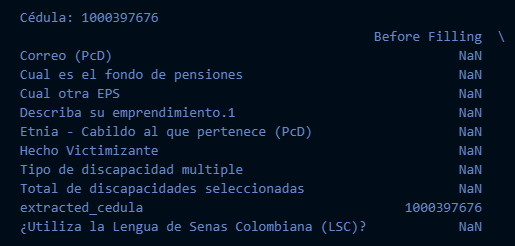